In [2]:
import xarray as xr
from dask.diagnostics import ProgressBar
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, Point
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm  # Optional: For progress tracking
import gc
import pyarrow as pa
import pyarrow.parquet as pq
import glob
from pathlib import Path
import re
from tqdm.notebook import tqdm
from shapely.vectorized import contains



In [3]:
def plot_geo_slice(
    xrobj: xr.Dataset | xr.DataArray,
    date: str | np.datetime64,
    var: str,
    lat_dim: str = "lat",
    lon_dim: str = "lon",
    title: str | None = None,
    cmap: str = "coolwarm",
    vmin: float | None = None,
    vmax: float | None = None,
    bounds: dict = None,  # Add bounds parameter
):
    """
    Static Matplotlib plot of *var* on the given date, automatically
    cropping to the non-NaN part of the domain (e.g. Iberia only).

    Parameters
    ----------
    xrobj : Dataset | DataArray   The source object (must contain *var*).
    date  : str | np.datetime64   Timestamp to display, e.g. "2060-10-01".
    var   : str                   Name of the variable to plot.
    bounds: dict                  Optional bounding box (e.g., {"min_lon": -10, "max_lon": 5, "min_lat": 35, "max_lat": 45}).
    ...   : see doc-string of the previous version.
    """

    # ── 1 · obtain the DataArray and slice the day ──────────────────────────
    da = xrobj if isinstance(xrobj, xr.DataArray) else xrobj[var]
    try:
        slab = da.sel(time=np.datetime64(date))
    except KeyError as err:
        raise ValueError(f"{date!s} not found") from err

    # ── 2 · drop lon / lat positions that are all NaN (global → Iberia) ────
    slab = slab.where(~np.isnan(slab), drop=True)

    # ── 3 · 0…360 → –180…180 for plotting; keep order monotonic ────────────
    lon = ((slab[lon_dim].values + 180.0) % 360.0) - 180.0
    lat = slab[lat_dim].values

    # If longitudes are no longer sorted after conversion, sort them together
    if np.any(np.diff(lon) < 0):
        sorter = np.argsort(lon)
        lon    = lon[sorter]
        slab   = slab.isel({lon_dim: sorter})

    Lon, Lat = np.meshgrid(lon, lat)
    data = slab.values.astype(float)

    # ── 4 · plot ────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6.5, 5.8), constrained_layout=True)
    pm = ax.pcolormesh(
        Lon, Lat, data,
        shading="auto",
        cmap=cmap,
        vmin=vmin, vmax=vmax,
    )
    cbar = fig.colorbar(pm, ax=ax, shrink=0.8)
    cbar.set_label(var)

    ax.set_xlabel("longitude (°)")
    ax.set_ylabel("latitude (°)")
    ax.set_title(title or f"{var} on {np.datetime_as_string(slab['time'].values, unit='D')}")

    # Tighten view to data extent or use provided bounds
    if bounds:
        ax.set_xlim(bounds["min_lon"], bounds["max_lon"])
        ax.set_ylim(bounds["min_lat"], bounds["max_lat"])
    else:
        ax.set_xlim(lon.min(), lon.max())
        ax.set_ylim(lat.min(), lat.max())

    ax.set_aspect("equal")
    ax.grid(True, linestyle="--", alpha=0.4)

    return fig, ax

import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt   # only for the static fallback

def explore_geo_dataNC(
    xrobj: xr.Dataset | xr.DataArray,
    date: str | np.datetime64,
    var: str,
    lat_dim: str = "lat",
    lon_dim: str = "lon",
    crs: str = "EPSG:4326",
    valid_time: str = "valid_time",

    interactive: bool = True,
):
    """
    Visualise a single-day field stored in an **xarray** object.

    Parameters
    ----------
    xrobj        : xarray.Dataset or xarray.DataArray
        Must contain the variable var and a time dimension.
    date         : str | np.datetime64
        Timestamp to extract (e.g. "2022-12-22").
    var          : str
        Name of the variable to display (e.g. "pr").
    lat_dim, lon_dim : str
        Dimension / coordinate names for latitude and longitude.
    crs          : str
        Target CRS for the GeoDataFrame (default EPSG:4326).
    interactive  : bool
        If True and geopandas >= 0.10 is installed, uses gdf.explore
        (leaflet); otherwise falls back to a static gdf.plot.
    """

    # ------------------------------------------------------------------ #
    # 1.  slice the xarray object to one time-step
    # ------------------------------------------------------------------ #
    if isinstance(xrobj, xr.DataArray):
        da = xrobj
    else:
        da = xrobj[var]

    try:
        slab = da.sel(time=np.datetime64(date))
    except KeyError:
        raise ValueError(f"date {date!s} not present in the dataset")

    # ------------------------------------------------------------------ #
    # 2.  convert to tabular form *once* (vectorised)
    # ------------------------------------------------------------------ #
    df = (
        slab.to_dataframe(name=var)
        .reset_index()
        .dropna(subset=[var])                       # keep valid cells only
        .astype({var: "float32"})
    )

    # shift 0 … 360 → −180 … 180 **in-place**
    df[lon_dim] = ((df[lon_dim] + 180.0) % 360.0) - 180.0

    # ------------------------------------------------------------------ #
    # 3.  GeoDataFrame & quick map
    # ------------------------------------------------------------------ #
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_dim].values, df[lat_dim].values),
        crs=crs,
    )
    gdf = gdf[gdf.geometry.within(nuts_iberia.union_all())]
    if interactive and hasattr(gdf, "explore"):
        return gdf.explore(column=var, cmap="coolwarm", tooltip=[var])
    else:
        ax = gdf.plot(column=var, cmap="coolwarm", legend=True,
                      figsize=(6, 6), markersize=8)
        ax.set_xlabel("lon"); ax.set_ylabel("lat"); plt.show()
        return ax

In [4]:

import unicodedata

# Function to normalize the names
def normalize_municipality_name(name):
    if type(name) == float:
        return name
    else:
        # Normalize the string (remove diacritical marks)
        name_without_diacritics = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('ascii')
        # Convert to lowercase
        return name_without_diacritics.lower()

mun_gdf = gpd.read_file(r'/Volumes/Dhruv_External_Disk/portugal_borders/concelhos-shapefile/concelhos.shp')
mun_metadata  = pd.read_excel(r'/Volumes/Dhruv_External_Disk/portugal_borders/concelhos-metadata.xlsx', dtype={'dicofre' : 'string'})
mun_metadata = mun_metadata[['dicofre','designacao']]

mun_gdf = mun_gdf.merge(mun_metadata, left_on='CCA_2', right_on='dicofre').drop(columns='NAME_2')
mun_gdf = mun_gdf.rename(columns={'designacao': 'NAME_2'})
mun_gdf['concelho'] = mun_gdf['NAME_2'].map(normalize_municipality_name)
mun_gdf = mun_gdf[~mun_gdf['NAME_1'].isin(['Azores', 'Madeira'])]
west_pt, south_pt, east_pt, north_pt = mun_gdf.total_bounds

In [5]:
nuts = gpd.read_file(r'/Volumes/Dhruv_External_Disk/portugal_borders/NUTS_RG_20M_2024_4326.shp/NUTS_RG_20M_2024_4326.shp')
nuts['NUTS_NAME'] = nuts['NUTS_NAME'].map(normalize_municipality_name)

nuts_iberia = nuts[(nuts['CNTR_CODE'].isin(['PT', 'ES'])) &  (nuts['LEVL_CODE'] == 2) & (~nuts['NUTS_NAME'].isin(['canarias', 'regiao autonoma dos acores', 'regiao autonoma da madeira', 'illes balears']))]
west, south, east, north = nuts_iberia.total_bounds

In [6]:
ntus_3_iberia = gpd.overlay(nuts[(nuts['CNTR_CODE'].isin(['PT', 'ES'])) &  (nuts['LEVL_CODE'] == 3) & (~nuts['NUTS_NAME'].isin(['canarias', 'regiao autonoma dos acores', 'regiao autonoma da madeira', 'illes balears']))], nuts_iberia, how='intersection')


/var/folders/nt/03y4p9md50gblp_0svv74zb80000gn/T/ipykernel_3076/1175415137.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 141 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ntus_3_iberia = gpd.overlay(nuts[(nuts['CNTR_CODE'].isin(['PT', 'ES'])) &  (nuts['LEVL_CODE'] == 3) & (~nuts['NUTS_NAME'].isin(['canarias', 'regiao autonoma dos acores', 'regiao autonoma da madeira', 'illes balears']))], nuts_iberia, how='intersection')


In [7]:
def explore_geo_data(df, date, column, lat_col='latitude', lon_col='longitude', crs="EPSG:4326", timecol = 'valid_time'):
    """
    Filters the DataFrame for a specific date, converts it to a GeoDataFrame with a CRS, and creates an interactive map.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        date (str): The date to filter the data (e.g., '1961-01-01').
        column (str): The column to visualize (e.g., 't2m').
        lat_col (str): The name of the latitude column.
        lon_col (str): The name of the longitude column.
        crs (str): The Coordinate Reference System to assign to the GeoDataFrame (default: "EPSG:4326").
    """
    # Filter the DataFrame for the specified date
    filtered_df = df[df[timecol] == date]
    filtered_df = filtered_df.dropna()
    #filtered_df = filtered_df.dropna()
    # Create a geometry column using shapely points
    filtered_df['geometry'] = filtered_df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
    print(filtered_df.head(2))
    # Convert the filtered DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')

    # Assign the CRS to the GeoDataFrame
    gdf = gdf.set_crs(crs)
    gdf = gdf[gdf.geometry.within(nuts_iberia.union_all())]

    # Use gdf.explore() for an interactive map
    return gdf.explore(column=column, cmap='coolwarm', legend=True)

# Example usage:
# Assuming `df` is your DataFrame
#explore_geo_data(testpq, date='1994-01-01', column='tp')

In [7]:
#ntus_3_iberia.to_file(r'/Volumes/Dhruv_External_Disk/portugal_borders/iberia_mainland/nuts3/nuts_3iberia_mainland.shp')

In [8]:
#nuts_iberia.to_file(r'/Volumes/Dhruv_External_Disk/portugal_borders/iberia_mainland/nuts2/nuts2_iberia_mainland.shp')

<Axes: >

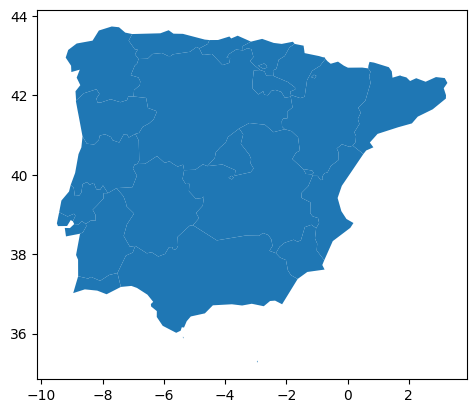

In [8]:
nuts_iberia.plot()

## Historical TP


#### 1. Build historical monthly climatology

In [9]:

# ---------------- paths
hist_nc = Path("/Volumes/Dhruv_External_Disk/climate_data/era5_land_monthlyavg_t2m_p.grib")

# ---------------- open & filter to 1950-01-01 … 1980-12-31
ds_full = xr.open_dataset(hist_nc)
ds_hist = ds_full.sel(time=slice("1950-01-01", "1980-12-31"))

# ---------------- monthly climatology (12 values per cell)
clim = xr.Dataset({
    "hist_t2m": ds_hist["t2m"].groupby("time.month").mean("time"),
    "hist_tp":  ds_hist["tp"] .groupby("time.month").mean("time")
})

# ---------------- to tidy DataFrames
df_t2m = clim[["hist_t2m"]].to_dataframe().reset_index().dropna()
df_tp  = clim[["hist_tp" ]].to_dataframe().reset_index().dropna()

# ---------------- write GeoParquet (Snappy)
df_t2m.to_parquet(
    "/Volumes/Dhruv_External_Disk/climate_data/temperature/"
    "era5_hist_monthly_clim_t2m_1950_1980.parquet",
    compression="snappy"
)
df_tp.to_parquet(
    "/Volumes/Dhruv_External_Disk/climate_data/precipitation/"
    "era5_hist_monthly_clim_tp_1950_1980.parquet",
    compression="snappy"
)

print("✔️ 12-month climatology files written.")


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/era5_land_monthlyavg_t2m_p.grib.5b7b6.idx' older than GRIB file
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


✔️ 12-month climatology files written.


In [12]:
hist_nc = Path("/Volumes/Dhruv_External_Disk/climate_data/era5_land_monthlyavg_t2m_p.grib")  # update with actual path
ds_hist = xr.open_dataset(hist_nc)

# Compute 1950-1992 monthly climatology for t2m and tp
hist_clim = xr.Dataset({
    "hist_t2m": ds_hist["t2m"].groupby("time.month").mean("time"),
    "hist_tp":  ds_hist["tp"].groupby("time.month").mean("time")
})

# Convert to DataFrame: lat, lon, month, hist_t2m, hist_tp
# df_hist_t2m = hist_clim.to_dataframe().reset_index()[["latitude", "longitude", "month", "hist_t2m"]].dropna()
df_hist_tp = hist_clim.to_dataframe().reset_index()[["latitude", "longitude", "month", "hist_tp"]].dropna()


# df_hist_t2m.to_parquet("/Volumes/Dhruv_External_Disk/climate_data/temperature/era5_historical_monthly_avg_t2m.parquet", compression="snappy")
df_hist_tp['hist_tp'] = df_hist_tp['hist_tp']* 1000
df_hist_tp.to_parquet("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/era5_historical_monthly_avg_tp.parquet", compression="snappy")



Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/era5_land_monthlyavg_t2m_p.grib.5b7b6.idx' older than GRIB file
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


### Clean TP Data

In [19]:

iberia_poly = nuts_iberia.union_all()              # mainland MultiPolygon
# ───────────────────────── paths
GRIB_DIR      = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly")
OUT_AVG_DIR   = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages")
OUT_TOTAL_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals")
OUT_AVG_DIR.mkdir(parents=True, exist_ok=True)
OUT_TOTAL_DIR.mkdir(parents=True, exist_ok=True)
import warnings
warnings.simplefilter("always", FutureWarning)

def build_allowed_ll(sample_ds: xr.Dataset) -> pd.DataFrame:
    lat, lon      = sample_ds.latitude.values, sample_ds.longitude.values
    lon2d, lat2d  = np.meshgrid(lon, lat)
    pts           = gpd.GeoSeries(gpd.points_from_xy(lon2d.ravel(), lat2d.ravel()), crs="EPSG:4326")
    mask          = pts.within(iberia_poly).values
    allowed       =         pd.DataFrame({
            "latitude":  lat2d.ravel()[mask],
            "longitude": lon2d.ravel()[mask]
        })
    return allowed.drop_duplicates()

# sample_path   = next(GRIB_DIR.glob("*.grib"))
# with xr.open_dataset(sample_path, engine="cfgrib") as _s:
#     allowed_ll  = build_allowed_ll(_s)
# allowed_lat = allowed_ll.latitude.unique()
# allowed_lon = allowed_ll.longitude.unique()

# ───────────────────────── parquet schema
schema = pa.schema([
    ("valid_time", pa.timestamp("ns")),
    ("latitude",   pa.float32()),
    ("longitude",  pa.float32()),
    ("tp",         pa.float32())
])

# ───────────────────────── yearly loop
yr_pat = re.compile(r"tp_hourly_(\d{4})\.grib")

for f in tqdm(sorted(GRIB_DIR.glob("tp_hourly_*.grib")), desc="Processing hourly GRIBs"):
    year    = int(yr_pat.search(f.name).group(1))
    # if year != 1995:          # ←   skip everything except 1995
    #     continue
    ds      = xr.open_dataset(f, engine="cfgrib").chunk({"time": 31, "step": 24})
    ds['tp'] = ds["tp"] * 1000
    allowed_ll = build_allowed_ll(ds)                  # ← moved inside
    print(f"File loaded: {f.name}") 
    df   = (
        ds["tp"]
        .to_dataframe()
        .reset_index()
        .dropna(subset=["tp"])
    )
    # single, full-precision join against our mask
    df = df.merge(allowed_ll, on=["latitude", "longitude"], how="inner")
    if df.empty:
        print(f"No Iberia points in {year}, skipping.")
        ds.close()
        del ds, df
        gc.collect()
        continue

    ds_clean  = df.set_index(["valid_time", "latitude", "longitude"]).to_xarray()

    # daily_avg   = ds_clean["tp"].resample(valid_time="1D").mean("valid_time")
    # daily_total = ds_clean["tp"].resample(valid_time="1D").sum("valid_time")
    # after resampling, drop all‐NaN days and locations:
    daily_avg = (
        ds_clean["tp"]
        .resample(valid_time="1D")
        .mean("valid_time")
        .dropna(dim="valid_time", how="all")
        .dropna(dim="latitude", how="all")
        .dropna(dim="longitude", how="all")
    )

    daily_total = (
        ds_clean["tp"]
        .resample(valid_time="1D")
        .sum("valid_time")
        .dropna(dim="valid_time", how="all")
        .dropna(dim="latitude", how="all")
        .dropna(dim="longitude", how="all")
    )

    for arr, out_dir, kind in (
        (daily_avg,   OUT_AVG_DIR,   "avg"),
        (daily_total, OUT_TOTAL_DIR, "total")
    ):
        tbl = pa.Table.from_pandas(
            arr.to_dataframe().reset_index().astype({
                "latitude":  "float32",
                "longitude": "float32",
                "tp":        "float32"
            }),
            schema=schema,
            preserve_index=False
        )
        pq.write_table(tbl, out_dir / f"tp_daily_{year}_{kind}.parquet", compression="snappy")
        print(f"File saved: {year} {kind} to {out_dir} / tp_daily_{year}_{kind}.parquet") 
    ds.close()
    del df, ds, ds_clean, daily_avg, daily_total
    gc.collect()


Processing hourly GRIBs:   0%|          | 0/74 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1950.grib
File saved: 1950 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1950_avg.parquet
File saved: 1950 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1950_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1951.grib
File saved: 1951 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1951_avg.parquet
File saved: 1951 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1951_total.parquet


skipping corrupted Message
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/messages.py", line 274, in itervalues
    yield self.filestream.message_from_file(file, errors=errors)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/messages.py", line 341, in message_from_file
    return Message.from_file(file, offset, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/messages.py", line 97, in from_file
    codes_id = eccodes.codes_grib_new_from_file(file)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gribapi/gribapi.py", line 415, in grib_new_from_file
    GRIB_CHECK(err)
  File "/Library/Frameworks/P

File loaded: tp_hourly_1952.grib
File saved: 1952 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1952_avg.parquet
File saved: 1952 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1952_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1953.grib
File saved: 1953 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1953_avg.parquet
File saved: 1953 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1953_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1954.grib
File saved: 1954 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1954_avg.parquet
File saved: 1954 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1954_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1955.grib
File saved: 1955 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1955_avg.parquet
File saved: 1955 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1955_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1956.grib
File saved: 1956 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1956_avg.parquet
File saved: 1956 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1956_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1957.grib
File saved: 1957 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1957_avg.parquet
File saved: 1957 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1957_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1958.grib
File saved: 1958 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1958_avg.parquet
File saved: 1958 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1958_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1959.grib
File saved: 1959 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1959_avg.parquet
File saved: 1959 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1959_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1960.grib
File saved: 1960 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1960_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1961.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1960 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1960_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1961.grib
File saved: 1961 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1961_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1962.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1961 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1961_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1962.grib
File saved: 1962 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1962_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1963.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1962 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1962_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1963.grib
File saved: 1963 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1963_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1964.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1963 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1963_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1964.grib
File saved: 1964 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1964_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1965.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1964 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1964_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1965.grib
File saved: 1965 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1965_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1966.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1965 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1965_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1966.grib
File saved: 1966 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1966_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1967.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1966 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1966_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1967.grib
File saved: 1967 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1967_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1968.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1967 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1967_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1968.grib
File saved: 1968 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1968_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1969.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1968 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1968_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1969.grib
File saved: 1969 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1969_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1970.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1969 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1969_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1970.grib
File saved: 1970 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1970_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1971.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1970 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1970_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1971.grib
File saved: 1971 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1971_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1972.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1971 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1971_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1972.grib
File saved: 1972 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1972_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1973.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1972 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1972_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1973.grib
File saved: 1973 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1973_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1974.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1973 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1973_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1974.grib
File saved: 1974 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1974_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1975.grib.5b7b6.idx' older than GRIB file


File saved: 1974 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1974_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1975.grib
File saved: 1975 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1975_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1976.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1975 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1975_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1976.grib
File saved: 1976 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1976_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1977.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1976 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1976_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1977.grib
File saved: 1977 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1977_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1978.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1977 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1977_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1978.grib
File saved: 1978 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1978_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1979.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1978 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1978_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1979.grib
File saved: 1979 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1979_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1980.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1979 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1979_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1980.grib
File saved: 1980 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1980_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1981.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1980 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1980_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1981.grib
File saved: 1981 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1981_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1982.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1981 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1981_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1982.grib
File saved: 1982 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1982_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1983.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1982 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1982_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1983.grib
File saved: 1983 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1983_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1984.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1983 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1983_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1984.grib
File saved: 1984 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1984_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1985.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1984 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1984_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1985.grib
File saved: 1985 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1985_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1986.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1985 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1985_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1986.grib
File saved: 1986 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1986_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1987.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1986 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1986_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1987.grib
File saved: 1987 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1987_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1988.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1987 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1987_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1988.grib
File saved: 1988 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1988_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1989.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1988 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1988_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1989.grib
File saved: 1989 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1989_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1990.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1989 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1989_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1990.grib
File saved: 1990 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1990_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1991.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1990 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1990_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1991.grib
File saved: 1991 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1991_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1992.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1991 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1991_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1992.grib
File saved: 1992 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1992_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1993.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1992 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1992_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1993.grib
File saved: 1993 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1993_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1994.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1993 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1993_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1994.grib
File saved: 1994 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1994_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1995.grib.5b7b6.idx' older than GRIB file


File saved: 1994 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1994_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1995.grib
File saved: 1995 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1995_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1996.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1995 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1995_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1996.grib
File saved: 1996 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1996_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1997.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1996 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1996_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1997.grib
File saved: 1997 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1997_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1998.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1997 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1997_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1998.grib
File saved: 1998 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1998_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_1999.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1998 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1998_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_1999.grib
File saved: 1999 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_1999_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2000.grib.5b7b6.idx' incompatible with GRIB file


File saved: 1999 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_1999_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2000.grib
File saved: 2000 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2000_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2001.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2000 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2000_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2001.grib
File saved: 2001 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2001_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2002.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2001 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2001_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2002.grib
File saved: 2002 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2002_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2003.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2002 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2002_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2003.grib
File saved: 2003 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2003_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2004.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2003 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2003_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2004.grib
File saved: 2004 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2004_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2005.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2004 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2004_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2005.grib
File saved: 2005 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2005_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2006.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2005 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2005_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2006.grib
File saved: 2006 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2006_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2007.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2006 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2006_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2007.grib
File saved: 2007 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2007_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2008.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2007 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2007_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2008.grib
File saved: 2008 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2008_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2009.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2008 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2008_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2009.grib
File saved: 2009 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2009_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2010.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2009 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2009_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2010.grib
File saved: 2010 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2010_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2011.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2010 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2010_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2011.grib
File saved: 2011 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2011_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2012.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2011 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2011_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2012.grib
File saved: 2012 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2012_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2013.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2012 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2012_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2013.grib
File saved: 2013 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2013_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2014.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2013 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2013_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2014.grib
File saved: 2014 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2014_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2015.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2014 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2014_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2015.grib
File saved: 2015 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2015_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2016.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2015 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2015_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2016.grib
File saved: 2016 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2016_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2017.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2016 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2016_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2017.grib
File saved: 2017 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2017_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2018.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2017 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2017_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2018.grib
File saved: 2018 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2018_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2019.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2018 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2018_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2019.grib
File saved: 2019 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2019_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2020.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2019 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2019_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2020.grib
File saved: 2020 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2020_avg.parquet
File saved: 2020 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2020_total.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2021.grib.5b7b6.idx' incompatible with GRIB file
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2021.grib
File saved: 2021 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2021_avg.parquet
File saved: 2021 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2021_total.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2022.grib.5b7b6.idx' incompatible with GRIB file
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2022.grib
File saved: 2022 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2022_avg.parquet


Ignoring index file '/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/hourly/tp_hourly_2023.grib.5b7b6.idx' incompatible with GRIB file


File saved: 2022 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2022_total.parquet


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


File loaded: tp_hourly_2023.grib
File saved: 2023 avg to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages / tp_daily_2023_avg.parquet
File saved: 2023 total to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals / tp_daily_2023_total.parquet


In [20]:
from pathlib import Path
import pandas as pd, numpy as np
from scipy.spatial import cKDTree
import pyarrow.parquet as pq, pyarrow as pa
from tqdm import tqdm
import gc

# 1. canonical grid from a good year (lat/lon already float32, 0.1 ° centres)
GRID_FILE = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals/tp_daily_1996_total.parquet")
good_pts  = (pd.read_parquet(GRID_FILE, columns=["latitude","longitude"])
               .drop_duplicates())
good_xy   = good_pts[["latitude","longitude"]].to_numpy()
tree      = cKDTree(good_xy)                     # ~11 k points

# 2. helper: snap a dataframe’s lat/lon columns to nearest 0.1 ° centre
def snap_to_grid(df: pd.DataFrame, lat_col="latitude", lon_col="longitude"):
    xy = df[[lat_col, lon_col]].to_numpy()
    dist, idx = tree.query(xy, k=1)
    snapped   = good_xy[idx]
    df[lat_col] = snapped[:,0].astype("float32")
    df[lon_col] = snapped[:,1].astype("float32")
    return df

# 3. repair loop for the seven years
BAD_YEARS = [1995]
DAILY_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals")
AVG_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/averages")
for yr in BAD_YEARS:
    f = DAILY_DIR / f"tp_daily_{yr}_total.parquet"
    if not f.exists():
        print("✗ file missing:", f); continue
    df = pd.read_parquet(f)
    df = snap_to_grid(df)
    group_cols = df.columns.difference(["tp"]).to_list()   # <- make a list
    df = (df.groupby(group_cols, sort=False, as_index=False)["tp"]
            .sum())

    # write back, overwriting
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_table(table, f, compression="snappy")
    del df, table; gc.collect()
    print("✓ grid-fixed", f.name)

for yr in BAD_YEARS:
    f = AVG_DIR / f"tp_daily_{yr}_avg.parquet"
    if not f.exists():
        print("✗ file missing:", f); continue
    df = pd.read_parquet(f)
    df = snap_to_grid(df)
    group_cols = df.columns.difference(["tp"]).to_list()   # <- make a list
    df = (df.groupby(group_cols, sort=False, as_index=False)["tp"]
            .sum())

    # write back, overwriting
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_table(table, f, compression="snappy")
    del df, table; gc.collect()
    print("✓ grid-fixed", f.name)


✓ grid-fixed tp_daily_1995_total.parquet
✓ grid-fixed tp_daily_1995_avg.parquet


### Create Monthly Variables

In [22]:
def filter_df_by_iberia(df, nuts_iberia = nuts_iberia, lat_col = 'latitude', lon_col = 'longitude'):
    """
    Filters a DataFrame to include only rows where latitude and longitude match the Iberia region.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing latitude and longitude columns.
        nuts_iberia (gpd.GeoDataFrame): GeoDataFrame representing the Iberia region.

    Returns:
        pd.DataFrame: Filtered DataFrame with rows matching the Iberia region.
    """
    # Extract unique latitude and longitude pairs
    df_lat_lon_unique = df[[lat_col, lon_col]].copy().drop_duplicates()

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df_lat_lon_unique,
        geometry=gpd.points_from_xy(
            x=df_lat_lon_unique[lon_col],
            y=df_lat_lon_unique[lat_col],
            crs="EPSG:4326"  # Coordinate Reference System
        )
    )
    gdf.plot()
    # Perform spatial intersection with Iberia region
    gdf_iberia = gpd.overlay(gdf, nuts_iberia, how="intersection")
    gdf_iberia.plot()
    # Filter the original DataFrame to keep only rows where latitude and longitude match
    filtered_df = df.merge(gdf_iberia[[lat_col, lon_col]], on=[lat_col, lon_col], how="inner")
    
    return filtered_df



#### Monthly Mean ($tp_{\mu}$)

In [48]:
DAILY_TOTAL_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals")
OUT_FILE        = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_mu.parquet")
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
if OUT_FILE.exists():
    OUT_FILE.unlink()                              # overwrite if rerun

schema = pa.schema([
    ("latitude", pa.float32()),
    ("longitude", pa.float32()),
    ("month", pa.timestamp("ms")),                 # month start in UTC
    ("tp_mu", pa.float32())
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")

for f in tqdm(sorted(DAILY_TOTAL_DIR.glob("tp_daily_*_total.parquet")),
              desc="Monthly mean:"):
    df = pd.read_parquet(f, columns=["valid_time", "latitude", "longitude", "tp"])
    df = df.dropna(subset=['tp'])
    # vectorised calendar truncation → month start
    df["month"] = df["valid_time"].dt.to_period("M").dt.to_timestamp()

    # group-by over ≤ 31 rows per group → C-level mean
    agg = ( df.groupby(["latitude", "longitude", "month"], sort=False)["tp"]
              .mean()
              .reset_index(name="tp_mu")            # wide to long
              .astype({"latitude":"float32",
                       "longitude":"float32",
                       "tp_mu":"float32"}) )

    writer.write_table(pa.Table.from_pandas(agg, schema=schema, preserve_index=False))

    del df, agg
    gc.collect()

writer.close()
print("✔ tp_mu written to", OUT_FILE)

Monthly mean:: 100%|██████████| 74/74 [00:33<00:00,  2.20it/s]

✔ tp_mu written to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_mu.parquet


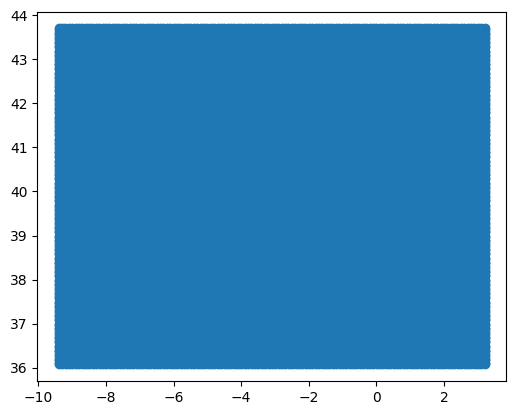

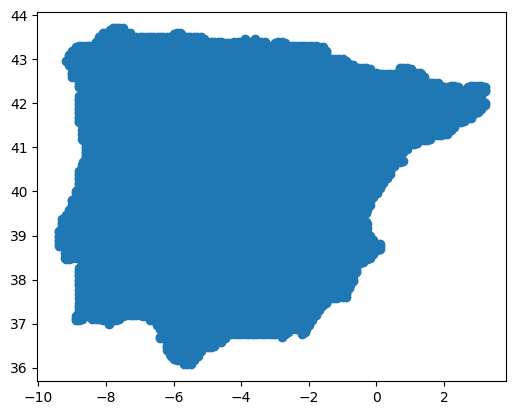

In [49]:
unfiltered_df = pd.read_parquet(OUT_FILE)
filtered_df = filter_df_by_iberia(unfiltered_df, nuts_iberia)
filtered_df.to_parquet(OUT_FILE)


### Historical Averages

In [51]:

IN_PAR   = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_mu.parquet")          # → contains “tp_mu”
OUT_PAR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/tp_historical_iberia_1950_1980.parquet")             # lat | lon | hist_tp
OUT_PAR.parent.mkdir(parents=True, exist_ok=True)
OUT_PAR.unlink(missing_ok=True)


df   = pd.read_parquet(IN_PAR)

# 2. limit to 1950-01 … 1980-12  (vectorised datetime mask) ----------------------
mask = (df["month"] >= "1950-01-01") & (df["month"] <= "1980-12-31")
hist = df.loc[mask, ["latitude", "longitude", "tp_mu"]]

# 3. average across the 31×12 months for each grid-cell --------------------------
hist_mu = (
    hist.groupby(["latitude", "longitude"], sort=False, observed=True)["tp_mu"]
        .mean()
        .reset_index(name="hist_tp")
)

# 4. write compact Parquet -------------------------------------------------------
hist_mu.to_parquet(OUT_PAR, index=False)

print("✔ overall historical mean →", OUT_PAR)



✔ overall historical mean → /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/tp_historical_iberia_1950_1980.parquet


#### Non Seasonal Historical Average

In [54]:
OUT_PAR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/tp_hist_monthly_iberia_1950_1980.parquet")
OUT_PAR.parent.mkdir(parents=True, exist_ok=True)
OUT_PAR.unlink(missing_ok=True)

# 1. read & slice ---------------------------------------------------------------
df    = pd.read_parquet(IN_PAR)

mask  = (df["month"] >= "1950-01-01") & (df["month"] <= "1980-12-31")
hist  = df.loc[mask].copy()

# 2. extract calendar-month (1…12) ---------------------------------------------
hist["MO"] = hist["month"].dt.month.astype("int8")

# 3. mean over all years *within each month* for every grid-cell ----------------
clim = (
    hist.groupby(["latitude", "longitude", "MO"], sort=False, observed=True)["tp_mu"]
        .mean()
        .reset_index(name="hist_tp")
)

# 4. write Parquet --------------------------------------------------------------
clim.to_parquet(OUT_PAR, index=False)

print("✔ monthly climatology written →", OUT_PAR)

✔ monthly climatology written → /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/tp_hist_monthly_iberia_1950_1980.parquet


#### Monthly Anomaly ($tp_{hd}$)

In [55]:


# ---- paths -----------------------------------------------------------------
SRC_PQ     = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_mu.parquet")                # monthly means
CLIM_PQ    = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/tp_historical_iberia_1950_1980.parquet")                # overall 1950-80 mean
OUT_PQ     = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_hd_overall.parquet")         # output
OUT_PQ.parent.mkdir(parents=True, exist_ok=True)
OUT_PQ.unlink(missing_ok=True)

# ---- load ------------------------------------------------------------------
df    = pd.read_parquet(SRC_PQ,     columns=["month", "latitude", "longitude", "tp_mu"])
clim  = pd.read_parquet(CLIM_PQ,    columns=["latitude", "longitude", "hist_tp"])

# ---- join & anomaly --------------------------------------------------------
merged = (
    df.merge(clim, on=["latitude", "longitude"], how="left", validate="m:1")
      .astype({"hist_tp": "float32"})                      # keep float32
)
merged["tp_hd"] = merged["tp_mu"] - merged["hist_tp"]

# ---- tidy & write ----------------------------------------------------------
out = merged[["month", "latitude", "longitude", "tp_hd"]]
out.to_parquet(OUT_PQ, index=False)

print("✔ deviation from overall climatology →", OUT_PQ)


✔ deviation from overall climatology → /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_hd_overall.parquet


In [56]:
# ---- paths -----------------------------------------------------------------
CLIM_PQ    = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/tp_hist_monthly_iberia_1950_1980.parquet")    # 12-month climatology
OUT_PQ     = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_hd_monthly.parquet")
OUT_PQ.parent.mkdir(parents=True, exist_ok=True)
OUT_PQ.unlink(missing_ok=True)

# ---- load ------------------------------------------------------------------
df   = pd.read_parquet(SRC_PQ)

# extract calendar-month (1-12) once – vectorised
df["month"] = df["month"].dt.month.astype("int8")

clim = pd.read_parquet(CLIM_PQ, columns=["latitude", "longitude", "MO", "hist_tp"])

# ---- join & anomaly --------------------------------------------------------
merged = (
    df.merge(clim, left_on=["latitude", "longitude", "month"], right_on=["latitude", "longitude", "MO"], how="left", validate="m:1")
)
merged["tp_hd"] = merged["tp_mu"] - merged["hist_tp"]

# ---- tidy & write ----------------------------------------------------------
out = merged[["month", "latitude", "longitude","tp_hd"]]
out.to_parquet(OUT_PQ, index=False)

print("✔ deviation from monthly climatology →", OUT_PQ)


✔ deviation from monthly climatology → /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_hd_monthly.parquet


#### Monthly Volatility ($tp_{\sigma \_mmday}$)

tp_std_mmday: 100%|██████████| 74/74 [00:31<00:00,  2.33it/s]


✔ tp_std_mmday written to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_std_mmday.parquet


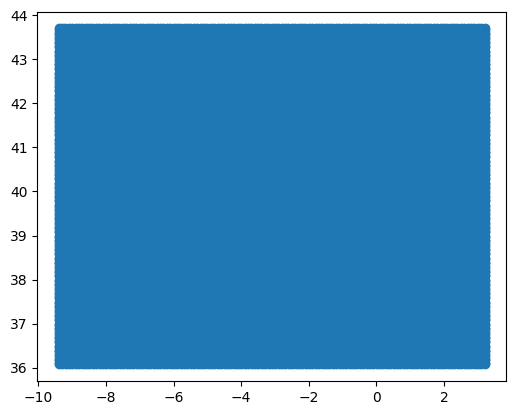

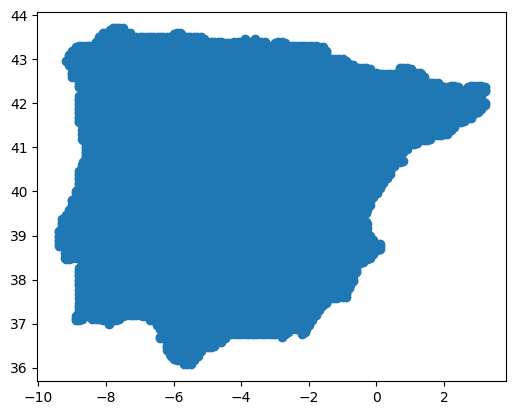

In [57]:

DAILY_TOTAL_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals")
OUT_FILE        = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/tp_std_mmday.parquet")
OUT_FILE.parent.mkdir(exist_ok=True, parents=True)
if OUT_FILE.exists():
    OUT_FILE.unlink()

schema = pa.schema([
    ("latitude",  pa.float32()),
    ("longitude", pa.float32()),
    ("month",     pa.timestamp("ms")),
    ("tp_std_mmday", pa.float32())
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")

for f in tqdm(sorted(DAILY_TOTAL_DIR.glob("tp_daily_*_total.parquet")),
              desc="tp_std_mmday"):
    df = pd.read_parquet(f, columns=["valid_time", "latitude", "longitude", "tp"])
    df["month"] = df["valid_time"].dt.to_period("M").dt.to_timestamp()

    agg = (df.groupby(["latitude", "longitude", "month"], sort=False)["tp"]
             .std()
             .reset_index(name="tp_std_mmday")
             .astype({"latitude":"float32", "longitude":"float32", "tp_std_mmday":"float32"}))

    writer.write_table(pa.Table.from_pandas(agg, schema=schema, preserve_index=False))
    del df, agg; gc.collect()

writer.close()
print("✔ tp_std_mmday written to", OUT_FILE)
unfiltered_df = pd.read_parquet(OUT_FILE)
filtered_df = filter_df_by_iberia(unfiltered_df, nuts_iberia)
filtered_df.to_parquet(OUT_FILE)


#### Monthly total of extreme precipitation extreme_tp_tot

In [58]:

DAILY_TOTAL_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals")
THR_FILE        = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/_tp99_thresholds.parquet")
OUT_FILE        = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/extreme_tp_tot.parquet")
OUT_FILE.parent.mkdir(exist_ok=True, parents=True)

# ── First pass: compute 99th-percentile threshold per grid-point ──────────────
if not THR_FILE.exists():
    thresh_accum = []
    for f in tqdm(sorted(DAILY_TOTAL_DIR.glob("tp_daily_*_total.parquet")),
                  desc="accum thresholds"):
        tmp = pd.read_parquet(f, columns=["latitude","longitude","tp"])
        thresh_accum.append(tmp)
    thr = (pd.concat(thresh_accum, ignore_index=True)
             .groupby(["latitude","longitude"], sort=False)["tp"]
             .quantile(0.99, interpolation="linear")
             .reset_index(name="thr99")
             .astype({"latitude":"float32","longitude":"float32","thr99":"float32"}))
    thr.to_parquet(THR_FILE, index=False)
    del thresh_accum, thr; gc.collect()

thr = pd.read_parquet(THR_FILE)

# ── Second pass: monthly sum of days exceeding threshold ─────────────────────
if OUT_FILE.exists():
    OUT_FILE.unlink()

schema = pa.schema([
    ("latitude",  pa.float32()),
    ("longitude", pa.float32()),
    ("month",     pa.timestamp("ms")),
    ("extreme_tp_tot", pa.float32())
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")

thr_lookup = thr.set_index(["latitude","longitude"])["thr99"]

# for f in tqdm(sorted(DAILY_TOTAL_DIR.glob("tp_daily_*_total.parquet")),
#               desc="extreme_tp_tot"):
#     df = pd.read_parquet(f, columns=["valid_time","latitude","longitude","tp"])
#     df["thr99"] = thr_lookup.loc[df.set_index(["latitude","longitude"]).index].values
#     df = df[df["tp"] > df["thr99"]]

#     if df.empty:
#         continue

#     df["month"] = df["valid_time"].dt.to_period("M").dt.to_timestamp()
#     agg = (df.groupby(["latitude","longitude","month"], sort=False)["tp"]
#              .sum()
#              .reset_index(name="extreme_tp_tot")
#              .astype({"latitude":"float32","longitude":"float32","extreme_tp_tot":"float32"}))

#     writer.write_table(pa.Table.from_pandas(agg, schema=schema, preserve_index=False))
#     del df, agg; gc.collect()


for f in tqdm(sorted(DAILY_TOTAL_DIR.glob("tp_daily_*_total.parquet")),
              desc="extreme_tp_tot"):

    df = pd.read_parquet(f, columns=["valid_time","latitude","longitude","tp"])

    # look-up threshold for each grid-cell
    df["thr99"] = thr_lookup.loc[
        df.set_index(["latitude","longitude"]).index
    ].values

    # keep all rows; only exceedances contribute to the sum
    df["ext_tp"] = np.where(df["tp"] > df["thr99"], df["tp"], 0.0).astype("float32")

    df["month"] = df["valid_time"].dt.to_period("M").dt.to_timestamp()

    agg = ( df.groupby(["latitude","longitude","month"], sort=False)["ext_tp"]
              .sum()
              .reset_index(name="extreme_tp_tot")
              .astype({"latitude":"float32",
                       "longitude":"float32",
                       "extreme_tp_tot":"float32"}) )

    writer.write_table(
        pa.Table.from_pandas(agg, schema=schema, preserve_index=False)
    )

    del df, agg; gc.collect()
writer.close()
print("✔ extreme_tp_tot written to", OUT_FILE)

extreme_tp_tot: 100%|██████████| 74/74 [00:56<00:00,  1.31it/s]

✔ extreme_tp_tot written to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/extreme_tp_tot.parquet


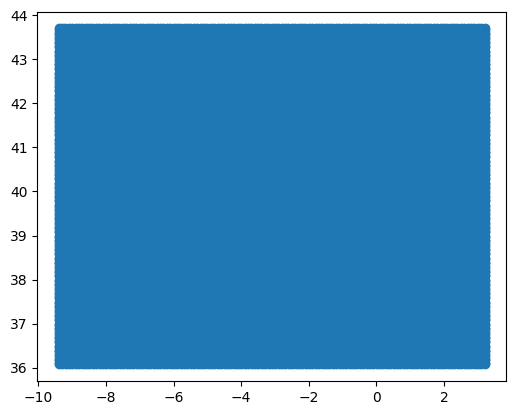

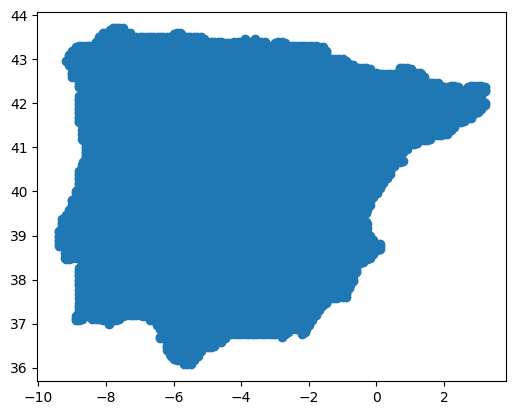

In [59]:
unfiltered_df = pd.read_parquet(OUT_FILE)
filtered_df = filter_df_by_iberia(unfiltered_df, nuts_iberia)
filtered_df.to_parquet(OUT_FILE)

#### Longest spell of consecutive dry days per month cdd

cdd: 100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


✔ cdd written to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/cdd.parquet


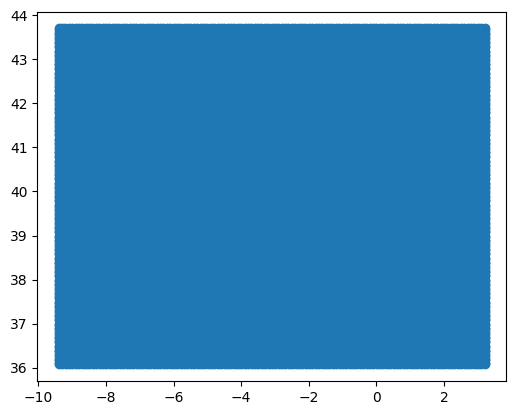

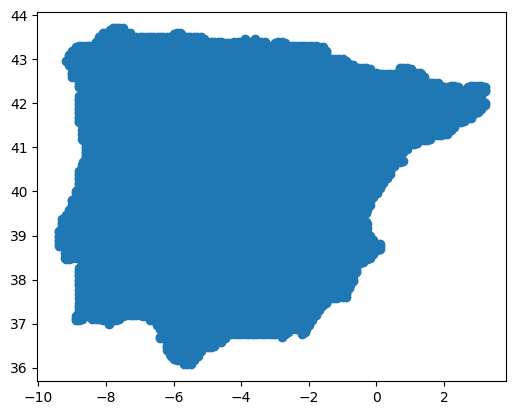

In [60]:


DAILY_TOTAL_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals")
OUT_FILE        = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/cdd.parquet")
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
if OUT_FILE.exists():
    OUT_FILE.unlink()

schema = pa.schema([
    ("latitude",  pa.float32()),
    ("longitude", pa.float32()),
    ("month",     pa.timestamp("ms")),
    ("cdd",       pa.int16())
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")

for f in tqdm(sorted(DAILY_TOTAL_DIR.glob("tp_daily_*_total.parquet")), desc="cdd"):
    # ──────────────────────────────────────────────────────────────────────────
    df = pd.read_parquet(
        f,
        columns=["valid_time", "latitude", "longitude", "tp"],
        engine="pyarrow"
    )
    df["month"]   = df["valid_time"].dt.to_period("M").dt.to_timestamp()
    df["is_dry"]  = df["tp"] < 1.0
    df = df.sort_values(["latitude", "longitude", "month", "valid_time"],
                        kind="mergesort")          # stable & fast for multi-key

    # ─── vectorised run-length encoding of dry spells ────────────────────────
    # A run starts when:    (a) previous row was wet  OR
    #                       (b) lat / lon / month changed
    shift_cols = df[["latitude", "longitude", "month"]].ne(
                     df[["latitude", "longitude", "month"]].shift()
                 ).any(axis=1)
    run_start  = (~df["is_dry"]) | shift_cols
    run_id     = run_start.cumsum().astype("int64").to_numpy()

    # Keep only dry-day rows, attach run_id
    dry = df.loc[df["is_dry"], ["latitude", "longitude", "month"]].copy()
    dry["run_id"] = run_id[df["is_dry"].to_numpy()]

    # length of each dry run (vectorised count)
    run_len = dry.groupby("run_id", sort=False).size().astype("int16")

    # annotate each dry row with length of its run
    dry["run_len"] = run_len.loc[dry["run_id"]].to_numpy()

    # # per (lat,lon,month) keep the maximum run length
    # cdd = (dry.groupby(["latitude", "longitude", "month"], sort=False)["run_len"]
    #           .max()
    #           .reset_index(name="cdd")
    #           .astype({"latitude":"float32",
    #                    "longitude":"float32",
    #                    "cdd":"int16"}))
    # per (lat,lon,month) keep the maximum run length
    cdd = (dry.groupby(["latitude", "longitude", "month"], sort=False)["run_len"]
              .max()
              .reset_index(name="cdd"))

    # ── NEW: ensure wet-only months get cdd = 0 ──────────────────────────────
    full_key = df[["latitude", "longitude", "month"]].drop_duplicates()
    cdd = (full_key
           .merge(cdd, on=["latitude", "longitude", "month"], how="left")
           .fillna({"cdd": 0})
           .astype({"latitude": "float32",
                    "longitude": "float32",
                    "cdd": "int16"}))

    if not cdd.empty:
        writer.write_table(pa.Table.from_pandas(cdd, schema=schema, preserve_index=False))

    del df, dry, cdd, run_len; gc.collect()


writer.close()
print("✔ cdd written to", OUT_FILE)

unfiltered_df = pd.read_parquet(OUT_FILE)
filtered_df = filter_df_by_iberia(unfiltered_df, nuts_iberia)
filtered_df.to_parquet(OUT_FILE)

#### Maximum 5-day accumulated precipitation per month max_5_day_

max_5_day_: 100%|██████████| 74/74 [02:00<00:00,  1.63s/it]


✔ max_5_day_ written to /Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/max_5_day_.parquet


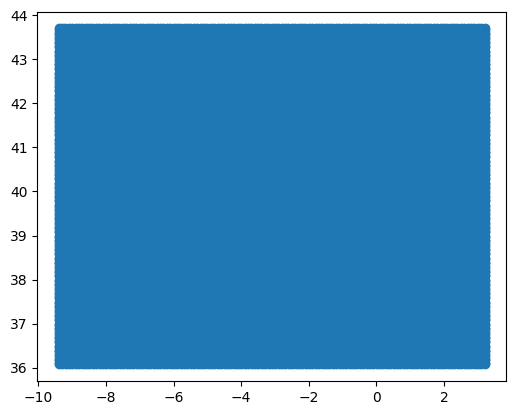

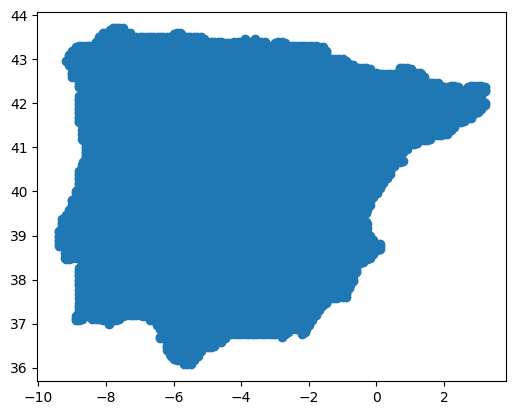

In [61]:


DAILY_TOTAL_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/daily/totals")
OUT_FILE        = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/monthly/max_5_day_.parquet")
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
if OUT_FILE.exists():
    OUT_FILE.unlink()

schema = pa.schema([
    ("latitude",   pa.float32()),
    ("longitude",  pa.float32()),
    ("month",      pa.timestamp("ms")),
    ("max_5_day_", pa.float32())
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")

for f in tqdm(sorted(DAILY_TOTAL_DIR.glob("tp_daily_*_total.parquet")),
              desc="max_5_day_"):

    # ── load one-year slice ──────────────────────────────────────────────────
    df = pd.read_parquet(
        f,
        columns=["valid_time", "latitude", "longitude", "tp"],
        engine="pyarrow"
    )

    # calendar month (month-start, UTC) – vectorised
    df["month"] = df["valid_time"].dt.to_period("M").dt.to_timestamp()

    # sort so that each lat-lon block is contiguous in time (stable O(n))
    df = df.sort_values(["latitude", "longitude", "valid_time"],
                        kind="mergesort")

    # ── vectorised 5-day rolling sum inside each grid-cell ──────────────────
    # pandas’ rolling kernel is C-level and much faster than Python loops
    roll5 = ( df.groupby(["latitude", "longitude"], sort=False)["tp"]
                .rolling(window=5, min_periods=5)
                .sum()
                .reset_index(level=[0,1], drop=True) )

    df["roll5"] = roll5.values           # align back without extra merge
    df = df.dropna(subset=["roll5"])     # rows with <5 preceding days

    # ── monthly maximum of the 5-day sums – fully vectorised aggregation ────
    agg = ( df.groupby(["latitude", "longitude", "month"], sort=False)["roll5"]
              .max()
              .reset_index(name="max_5_day_")
              .astype({"latitude":  "float32",
                       "longitude": "float32",
                       "max_5_day_":"float32"}) )

    if not agg.empty:
        writer.write_table(
            pa.Table.from_pandas(agg, schema=schema, preserve_index=False)
        )

    del df, roll5, agg
    gc.collect()

writer.close()
print("✔ max_5_day_ written to", OUT_FILE)

unfiltered_df = pd.read_parquet(OUT_FILE)
filtered_df = filter_df_by_iberia(unfiltered_df, nuts_iberia)
filtered_df.to_parquet(OUT_FILE)

## Projections

### Daily Data

### SSP 245 and RCP 4.5

#### Clean

In [13]:
# ─── Inspect CMIP-6 grid against Iberia polygon (no data load) ──────────────
from pathlib import Path
import xarray as xr, geopandas as gpd, numpy as np
from shapely.vectorized import contains
CMIP6_FILE  = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/cmip6/MPI-ESM1-2LR/SSP245NASA/pr_day_MPI-ESM1-2-LR_ssp245_r1i1p1f1_gn_2021_v2.0.nc")
IBE_POLY    = nuts_iberia.copy().union_all().buffer(0.125)
# 1. open lazily, read only coordinate axes ----------------------------------
ds  = xr.open_dataset(CMIP6_FILE)
lat = ds["lat"].values                     # (580,)
lon0_360 = ds["lon"].values                # (1421,)  0…360°
lon = ((lon0_360 + 180) % 360) - 180       # convert to −180…180°

print(f"DS latitude range : {lat.min():.2f} → {lat.max():.2f}")
print(f"DS longitude range: {lon.min():.2f} → {lon.max():.2f}")

# 2. vectorised point-in-polygon --------------------------------------------
lon2d, lat2d = np.meshgrid(lon, lat, indexing="xy")
mask = contains(IBE_POLY, lon2d, lat2d)    # bool (lat, lon)

lat_valid = np.unique(lat2d[mask]).astype("float32")
lon_valid = np.unique(lon2d[mask]).astype("float32")
west, south, east, north = nuts_iberia.total_bounds
IBERIA_BBOX = {
    "min_lat": south,  # Minimum latitude
    "max_lat": north,  # Maximum latitude
    "min_lon": west,   # Minimum longitude
    "max_lon": east    # Maximum longitude
}
print("Iberia BBOX from IBE_POLY")
print(IBERIA_BBOX)
print(f"\nValid Iberia latitudes ({lat_valid.size}):",
      np.array2string(lat_valid[:10], precision=2, separator=', '), "…")
print(f"Valid Iberia longitudes ({lon_valid.size}):",
      np.array2string(lon_valid[:10], precision=2, separator=', '), "…")

# 3. bounding box of those valid cells
print("\nBounding box of Iberia cells in this file:")
print(f"  lat : {lat_valid.min():.2f} → {lat_valid.max():.2f}")
print(f"  lon : {lon_valid.min():.2f} → {lon_valid.max():.2f}")

ds.close()


DS latitude range : -59.88 → 89.88
DS longitude range: -179.88 → 179.88
Iberia BBOX from IBE_POLY
{'min_lat': 35.271704476000025, 'max_lat': 43.735114829000054, 'min_lon': -9.490672837999966, 'max_lon': 3.25861242000002}

Valid Iberia latitudes (33): [35.38, 35.88, 36.12, 36.38, 36.62, 36.88, 37.12, 37.38, 37.62, 37.88] …
Valid Iberia longitudes (51): [-9.38, -9.12, -8.88, -8.62, -8.38, -8.12, -7.88, -7.62, -7.38, -7.12] …

Bounding box of Iberia cells in this file:
  lat : 35.38 → 43.62
  lon : -9.38 → 3.12


In [28]:
import xarray as xr, numpy as np, tqdm
from shapely.vectorized import contains
from pathlib import Path
from dask import delayed

SRC_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/"
               "cmip6/MPI-ESM1-2LR/SSP245NASA")
OUT_NC = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/"
              "cmip6/cmip6_pr_iberia.nc")
OUT_NC.unlink(missing_ok=True)

files = sorted(SRC_DIR.glob("pr_day_MPI-ESM1-2-LR_ssp245_*.nc"))

# mask (same code as above) ---------------------------------------------------
with xr.open_dataset(files[0]) as tmpl:
    lon = ((tmpl.lon.values + 180) % 360) - 180
    lat = tmpl.lat.values
lon2d, lat2d = np.meshgrid(lon, lat, indexing="xy")
mask = contains(nuts_iberia.union_all(), lon2d, lat2d)

# lazily build a list of masked datasets -------------------------------------
subsets = []
for f in tqdm.tqdm(files, desc="open+mask"):
    ds = xr.open_dataset(f, chunks={"time": 365})
    subsets.append(ds.where(mask))

# concat along time *without computing* ---------------------------------------
full = xr.concat(subsets, dim="time")

encoding = {"pr": {"dtype": "float32", "zlib": True, "complevel": 4}}
full.to_netcdf(OUT_NC, format="NETCDF4",
               unlimited_dims="time", encoding=encoding)

print("✔ Iberia subset written:", OUT_NC)


open+mask: 100%|██████████| 60/60 [00:00<00:00, 90.47it/s] 


✔ Iberia subset written: /Volumes/Dhruv_External_Disk/climate_data/precipitation/cmip6/cmip6_pr_iberia.nc


### Monthly Data

In [10]:


# Iberia bounding box ---------------------------------------------------------

def subset_iberia(ds: xr.Dataset | xr.DataArray,
                  lat_dim: str = "lat",
                  lon_dim: str = "lon") -> xr.Dataset | xr.DataArray:
    """
    Return the Iberia window of *ds* (lazy).  Handles a 0…360° longitude axis
    by wrapping it to –180…180° and sorting it once.

    Parameters
    ----------
    ds : Dataset | DataArray
    lat_dim, lon_dim : str   names of the spatial dimensions
    """
    # --- 1 · wrap longitudes if necessary -----------------------------------
    west, south, east, north = nuts_iberia.total_bounds      # lon/lat in °

    if float(ds[lon_dim].max()) > 180.0:
        print("greater")
        # (a) wrap
        lon_wrapped = (((ds[lon_dim] + 180.0) % 360.0) - 180.0)
        # (b) make a sorted copy of the *coordinate only* – cheap
        order = np.argsort(lon_wrapped.values)
        ds = ds.assign_coords({lon_dim: lon_wrapped}).isel({lon_dim: order})

    # 2. boolean masks for the 1-D coordinate axes
    lat_mask = (ds[lat_dim] >= south) & (ds[lat_dim] <= north)
    lon_mask = (ds[lon_dim] >= west)  & (ds[lon_dim] <= east)

    # 3. isel with index arrays (avoids broadcasting issues)
    ds = ds.isel(
        **{
            lat_dim: np.where(lat_mask)[0],
            lon_dim: np.where(lon_mask)[0],
        }
    )
    return ds
# example
#cmip6_df_iberia = subset_iberia(cmip6_df_iberia)


In [13]:
cmip6_df_iberia

<xarray.Dataset> Size: 152MB
Dimensions:  (time: 21915, lat: 34, lon: 51)
Coordinates:
  * time     (time) datetime64[ns] 175kB 2021-01-01T12:00:00 ... 2080-12-31T1...
  * lat      (lat) float64 272B 35.38 35.62 35.88 36.12 ... 43.12 43.38 43.62
  * lon      (lon) float64 408B -9.375 -9.125 -8.875 ... 2.625 2.875 3.125
Data variables:
    pr       (time, lat, lon) float32 152MB ...
Attributes: (12/21)
    cmip6_source_id:       MPI-ESM1-2-LR
    cmip6_institution_id:  MPI-M
    cmip6_license:         CC-BY 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    resolution_id:         0.25 degree
    external_variables:    areacella
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 04:39:32 PST 2024
    disclaimer:            These data are considered provisional and subject ...
    tracking_id:           0d102568-28ff-4e6b-9300-2c4d8a7fbb7b

### $tp_{\mu}$

In [ ]:


SRC_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
               "cmip6/MPI-ESM1-2LR/daily")
OUT_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
               "cmip6/MPI-ESM1-2LR/monthly/tp_mu")
OUT_DIR.mkdir(parents=True, exist_ok=True)

files = sorted(SRC_DIR.glob("pr_day_MPI-ESM1-2-LR_ssp245_*.nc"))

# mask -----------------------------------------------------------------------
with xr.open_dataset(files[0]) as tmpl:
    lon = ((tmpl.lon.values + 180) % 360) - 180
    lat = tmpl.lat.values
lon2d, lat2d = np.meshgrid(lon, lat, indexing="xy")
mask_da = xr.DataArray(
    contains(nuts_iberia.union_all(), lon2d, lat2d),
    coords={"lat": lat, "lon": lon},
    dims=("lat", "lon"),
)

mu_enc = {"tp_mu": {"dtype": "float32", "zlib": True, "complevel": 4}}

for f in tqdm.tqdm(files, desc="process"):
    year = f.stem.split("_")[-2]          # → "2079"
    out_year = OUT_DIR / f"cmip6_pr_iberia_mu_{year}.nc"

    with xr.open_dataset(f, decode_times=True) as ds:
        ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
        ds = ds.transpose("time", "lat", "lon").where(mask_da).astype("float32")

        mu = ds["pr"].resample(time="MS").mean("time", skipna=False).rename("tp_mu")
        mu.to_netcdf(
            out_year,
            format="NETCDF4",
            encoding=mu_enc,
        )

print("✔ yearly monthly means written to →", OUT_DIR)


process:   0%|          | 0/60 [00:00<?, ?it/s]

2021


process:   2%|▏         | 1/60 [00:02<02:28,  2.51s/it]

2022


process:   3%|▎         | 2/60 [00:05<02:29,  2.58s/it]

2023


process:   5%|▌         | 3/60 [00:07<02:26,  2.57s/it]

2024


process:   7%|▋         | 4/60 [00:10<02:18,  2.48s/it]

2025


process:   8%|▊         | 5/60 [00:12<02:19,  2.53s/it]

2026


process:  10%|█         | 6/60 [00:15<02:15,  2.50s/it]

2027


process:  12%|█▏        | 7/60 [00:17<02:12,  2.50s/it]

2028


process:  13%|█▎        | 8/60 [00:20<02:12,  2.55s/it]

2029


process:  15%|█▌        | 9/60 [00:22<02:11,  2.59s/it]

2030


process:  17%|█▋        | 10/60 [00:25<02:08,  2.57s/it]

2031


process:  18%|█▊        | 11/60 [00:28<02:07,  2.60s/it]

2032


process:  20%|██        | 12/60 [00:30<02:03,  2.58s/it]

2033


process:  22%|██▏       | 13/60 [00:33<01:59,  2.55s/it]

2034


process:  23%|██▎       | 14/60 [00:35<01:56,  2.53s/it]

2035


process:  25%|██▌       | 15/60 [00:38<01:52,  2.51s/it]

2036


process:  27%|██▋       | 16/60 [00:40<01:51,  2.54s/it]

2037


process:  28%|██▊       | 17/60 [00:43<01:50,  2.56s/it]

2038


process:  30%|███       | 18/60 [00:45<01:46,  2.53s/it]

2039


process:  32%|███▏      | 19/60 [00:48<01:44,  2.56s/it]

2040


process:  33%|███▎      | 20/60 [00:51<01:43,  2.59s/it]

2041


process:  35%|███▌      | 21/60 [00:53<01:39,  2.56s/it]

2042


process:  37%|███▋      | 22/60 [00:55<01:33,  2.47s/it]

2043


process:  38%|███▊      | 23/60 [00:58<01:31,  2.47s/it]

2044


process:  40%|████      | 24/60 [01:00<01:29,  2.49s/it]

2045


process:  42%|████▏     | 25/60 [01:03<01:27,  2.50s/it]

2046


process:  43%|████▎     | 26/60 [01:05<01:24,  2.49s/it]

2047


process:  45%|████▌     | 27/60 [01:08<01:22,  2.51s/it]

2048


process:  47%|████▋     | 28/60 [01:10<01:19,  2.49s/it]

2049


process:  48%|████▊     | 29/60 [01:13<01:16,  2.48s/it]

2050


process:  50%|█████     | 30/60 [01:15<01:14,  2.48s/it]

2051


process:  52%|█████▏    | 31/60 [01:18<01:11,  2.47s/it]

2052


process:  53%|█████▎    | 32/60 [01:20<01:09,  2.48s/it]

2053


process:  55%|█████▌    | 33/60 [01:23<01:06,  2.46s/it]

2054


process:  57%|█████▋    | 34/60 [01:25<01:04,  2.46s/it]

2055


process:  58%|█████▊    | 35/60 [01:27<01:01,  2.46s/it]

2056


process:  60%|██████    | 36/60 [01:30<00:58,  2.44s/it]

2057


process:  62%|██████▏   | 37/60 [01:32<00:55,  2.43s/it]

2058


process:  63%|██████▎   | 38/60 [01:35<00:53,  2.42s/it]

2059


process:  65%|██████▌   | 39/60 [01:37<00:50,  2.41s/it]

2060


process:  67%|██████▋   | 40/60 [01:39<00:48,  2.42s/it]

2061


process:  68%|██████▊   | 41/60 [01:42<00:45,  2.41s/it]

2062


process:  70%|███████   | 42/60 [01:44<00:43,  2.40s/it]

2063


process:  72%|███████▏  | 43/60 [01:47<00:40,  2.41s/it]

2064


process:  73%|███████▎  | 44/60 [01:49<00:39,  2.44s/it]

2065


process:  75%|███████▌  | 45/60 [01:52<00:36,  2.45s/it]

2066


process:  77%|███████▋  | 46/60 [01:54<00:34,  2.46s/it]

2067


process:  78%|███████▊  | 47/60 [01:57<00:31,  2.46s/it]

2068


process:  80%|████████  | 48/60 [01:59<00:29,  2.47s/it]

2069


process:  82%|████████▏ | 49/60 [02:02<00:27,  2.47s/it]

2070


process:  83%|████████▎ | 50/60 [02:04<00:24,  2.49s/it]

2071


process:  85%|████████▌ | 51/60 [02:07<00:22,  2.49s/it]

2072


process:  87%|████████▋ | 52/60 [02:09<00:19,  2.49s/it]

2073


process:  88%|████████▊ | 53/60 [02:11<00:17,  2.46s/it]

2074


process:  90%|█████████ | 54/60 [02:14<00:14,  2.47s/it]

2075


process:  92%|█████████▏| 55/60 [02:16<00:12,  2.47s/it]

2076


process:  93%|█████████▎| 56/60 [02:19<00:09,  2.45s/it]

2077


process:  95%|█████████▌| 57/60 [02:21<00:07,  2.44s/it]

2078


process:  97%|█████████▋| 58/60 [02:24<00:04,  2.45s/it]

2079


process:  98%|█████████▊| 59/60 [02:26<00:02,  2.48s/it]

2080


process: 100%|██████████| 60/60 [02:29<00:00,  2.49s/it]

✔ yearly monthly means written to → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/monthly/tp_mu


In [15]:
 
MONTHLY_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
                   "cmip6/MPI-ESM1-2LR/monthly/tp_mu")
OUT_FILE    = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
                   "cmip6/MPI-ESM1-2LR/monthly/tp_mu.parquet")
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
if OUT_FILE.exists():
    OUT_FILE.unlink()                       # overwrite on rerun

schema = pa.schema([
    ("latitude",  pa.float32()),
    ("longitude", pa.float32()),
    ("month",     pa.timestamp("ms")),      # UTC month start
    ("tp_mu",     pa.float32()),
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")
for f in tqdm(sorted(MONTHLY_DIR.glob("cmip6_pr_iberia_mu_*.nc")),
                   desc="Iberia monthly → parquet"):
    with xr.open_dataset(f) as ds:
        ds = subset_iberia(ds)                      # keep Dataset
        # wide→long: Dataset → DataFrame → reset_index (vectorised)
        df = (ds
              .to_dataframe()                       # cols: tp_mu ; idx: time, lat, lon
              .reset_index()                        # now explicit columns
              .rename(columns={"lat": "latitude",
                               "lon": "longitude",
                               "time": "month"})
              .astype({"latitude": "float32",
                       "longitude": "float32",
                       "tp_mu":   "float32"}))
        df["tp_mu"] = df["tp_mu"] * np.float32(86_400.0)
        df["month"] = pd.to_datetime(df["month"], utc=True)   # ms precision

        writer.write_table(pa.Table.from_pandas(df, schema=schema,
                                                preserve_index=False))
        del df
        gc.collect()
writer.close()
print("✔ tp_mu parquet written →", OUT_FILE)


Iberia monthly → parquet:   0%|          | 0/60 [00:00<?, ?it/s]

✔ tp_mu parquet written → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/monthly/tp_mu.parquet


#### tp_hd

##### Historical Average Overall

In [43]:
# ---------------------------------------------------------------------------
# overall deviation: CMIP6 monthly mean minus nearest ERA5 climatology
# ---------------------------------------------------------------------------
from scipy.spatial import cKDTree

TP_MU_FILE = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
                  "cmip6/MPI-ESM1-2LR/monthly/tp_mu.parquet")
HIST_FILE  = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/"
                  "tp_historical_iberia_1950_1980.parquet")
OUT_HD     = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
                  "cmip6/MPI-ESM1-2LR/monthly/tp_hd_overall.parquet")
OUT_HD.unlink(missing_ok=True)

# ---- load ------------------------------------------------------------------
df   = pd.read_parquet(TP_MU_FILE)
clim = pd.read_parquet(HIST_FILE)

# unify longitude range to −180…180°
df["longitude"]   = (((df["longitude"]   + 180.0) % 360.0) - 180.0).astype("float32")
clim["longitude"] = (((clim["longitude"] + 180.0) % 360.0) - 180.0).astype("float32")

# ---- nearest-neighbour lookup ---------------------------------------------
tree = cKDTree(clim[["latitude","longitude"]].to_numpy(dtype="float32"))
_, idx = tree.query(df[["latitude","longitude"]].to_numpy(dtype="float32"), k=1)

df["hist_tp"] = clim["hist_tp"].to_numpy(dtype="float32")[idx]

# ---- deviation -------------------------------------------------------------
df["tp_hd"] = df["tp_mu"].astype("float32") - df["hist_tp"]

df[["month","latitude","longitude","tp_hd"]].to_parquet(OUT_HD, index=False)
print("✔ deviation from overall climatology →", OUT_HD)


✔ deviation from overall climatology → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/monthly/tp_hd_overall.parquet


##### Non Seasonal Historical Average

In [45]:

# ── paths ─────────────────────────────────────────────────────────────────
TP_MU_FILE  = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
                   "cmip6/MPI-ESM1-2LR/monthly/tp_mu.parquet")
HIST_M_FILE = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/"
                   "tp_hist_monthly_iberia_1950_1980.parquet")
OUT_HD_M    = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
                   "cmip6/MPI-ESM1-2LR/monthly/tp_hd_monthly.parquet")
OUT_HD_M.unlink(missing_ok=True)

# ── load CMIP6 monthly means ──────────────────────────────────────────────
df = pd.read_parquet(TP_MU_FILE)


# numeric calendar month (1–12) for climatology match
df["MO"] = pd.to_datetime(df["month"]).dt.month.astype("int8")

# ensure longitude range −180…180°
df["longitude"] = (((df["longitude"] + 180.0) % 360.0) - 180.0).astype("float32")

# ── load historical month-specific means ──────────────────────────────────
clim = pd.read_parquet(HIST_M_FILE)


# ── build cKDTree on unique ERA5 gridpoints ───────────────────────────────
pivot = clim.pivot_table(index=["latitude", "longitude"], columns="MO", values="hist_tp")
coords = np.array(pivot.index.to_list(), dtype="float32")      # N × 2 (lat, lon)
hist_mat = pivot.to_numpy(dtype="float32")                     # N × 12

tree = cKDTree(coords)

# ── nearest neighbour lookup for each CMIP6 row ───────────────────────────
_, idx = tree.query(df[["latitude", "longitude"]].to_numpy(dtype="float32"), k=1)
df["hist_tp"] = hist_mat[idx, df["MO"] - 1]                    # 0-based month

# ── deviation ─────────────────────────────────────────────────────────────
df["tp_hd"] = df["tp_mu"] - df["hist_tp"]

# ── tidy & save ───────────────────────────────────────────────────────────
df[["month", "latitude", "longitude", "tp_hd"]].to_parquet(OUT_HD_M, index=False)

print("✔ deviation from month-specific climatology →", OUT_HD_M)


✔ deviation from month-specific climatology → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/monthly/tp_hd_monthly.parquet


In [46]:
pd.read_parquet(OUT_HD_M)

,month,latitude,longitude,tp_hd
0,2021-01-01,35.375,0.125,NaN
1,2021-02-01,35.375,0.125,NaN
2,2021-03-01,35.375,0.125,NaN
3,2021-04-01,35.375,0.125,NaN
4,2021-05-01,35.375,0.125,NaN
...,...,...,...,...
1248475,2080-08-01,43.625,-0.125,NaN
1248476,2080-09-01,43.625,-0.125,NaN
1248477,2080-10-01,43.625,-0.125,NaN
1248478,2080-11-01,43.625,-0.125,NaN


### $tp_{\sigma}$

In [20]:


SRC_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
               "cmip6/MPI-ESM1-2LR/daily")
OUT_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
               "cmip6/MPI-ESM1-2LR/monthly/tp_sigma")
OUT_DIR.mkdir(parents=True, exist_ok=True)

files = sorted(SRC_DIR.glob("pr_day_MPI-ESM1-2-LR_ssp245_*.nc"))

# mask -----------------------------------------------------------------------
with xr.open_dataset(files[0]) as tmpl:
    lon = ((tmpl.lon.values + 180) % 360) - 180
    lat = tmpl.lat.values
lon2d, lat2d = np.meshgrid(lon, lat, indexing="xy")
mask_da = xr.DataArray(
    contains(nuts_iberia.union_all(), lon2d, lat2d),
    coords={"lat": lat, "lon": lon},
    dims=("lat", "lon"),
)

std_enc = {"tp_std": {"dtype": "float32", "zlib": True, "complevel": 4}}
for f in tqdm(files, desc="process"):
    year = f.stem.split("_")[-2]          # → "2079"
    out_year = OUT_DIR / f"cmip6_pr_iberia_std_{year}.nc"

    with xr.open_dataset(f, decode_times=True) as ds:
        ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
        ds = ds.transpose("time", "lat", "lon").where(mask_da).astype("float32")
        # 86 400 s per day; 1 kg m⁻² = 1 mm
        sigma = (
            ds["pr"] * np.float32(86_400.0)                      # kg m⁻² s⁻¹ → mm day⁻¹
        ).resample(time="MS").std("time", skipna=False).rename("tp_std")

        sigma.to_netcdf(
            out_year,
            format="NETCDF4",
            encoding=std_enc,
        )

print("✔ yearly monthly means written to →", OUT_DIR)


process:   0%|          | 0/60 [00:00<?, ?it/s]

✔ yearly monthly means written to → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/monthly/tp_sigma


In [21]:
 
MONTHLY_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
               "cmip6/MPI-ESM1-2LR/monthly/tp_sigma")
OUT_FILE    = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/"
                   "cmip6/MPI-ESM1-2LR/monthly/tp_stdmmday.parquet")
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
if OUT_FILE.exists():
    OUT_FILE.unlink()                       # overwrite on rerun

schema = pa.schema([
    ("latitude",  pa.float32()),
    ("longitude", pa.float32()),
    ("month",     pa.timestamp("ms")),      # UTC month start
    ("tp_std",     pa.float32()),
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")
for f in tqdm(sorted(MONTHLY_DIR.glob("cmip6_pr_iberia_std_*.nc")),
                   desc="Iberia monthly → parquet"):
    with xr.open_dataset(f) as ds:
        ds = subset_iberia(ds)                      # keep Dataset
        # wide→long: Dataset → DataFrame → reset_index (vectorised)
        df = (ds
              .to_dataframe()                       # cols: tp_std ; idx: time, lat, lon
              .reset_index()                        # now explicit columns
              .rename(columns={"lat": "latitude",
                               "lon": "longitude",
                               "time": "month"})
              .astype({"latitude": "float32",
                       "longitude": "float32",
                       "tp_std":   "float32"}))
        df["month"] = pd.to_datetime(df["month"], utc=True)   # ms precision

        writer.write_table(pa.Table.from_pandas(df, schema=schema,
                                                preserve_index=False))
        del df
        gc.collect()
writer.close()
print("✔ tp_std parquet written →", OUT_FILE)


Iberia monthly → parquet:   0%|          | 0/60 [00:00<?, ?it/s]

✔ tp_std parquet written → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/monthly/tp_stdmmday.parquet


### ECDE

#### *cdd*

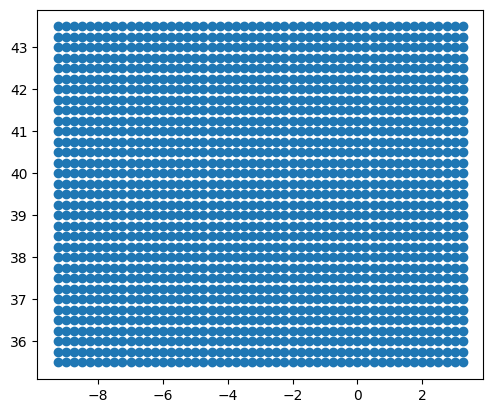

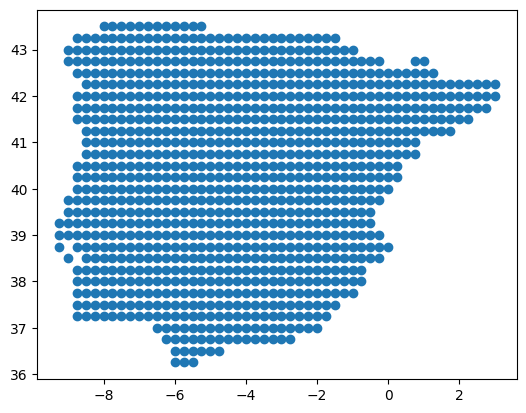

In [19]:
cdd_df = xr.open_dataset(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/ecde_proj_4_5_france/18_consecutive_dry_days-projections-monthly-rcp_4_5-wrf381p-ipsl_cm5a_mr-r1i1p1-grid-v1.0.nc')
cdd_df = subset_iberia(cdd_df)
cdd_df = cdd_df.to_dataframe().reset_index()
cdd_df = filter_df_by_iberia(cdd_df, nuts_iberia, lat_col='lat', lon_col='lon')

In [22]:
cdd_df.to_parquet('/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/ecde_proj_4_5_france/monthly/cdd_iberia_1951_2100.parquet')


In [20]:
explore_geo_data(cdd_df, '2070-07-01', 'cdd', timecol='time', lat_col='lat', lon_col='lon')

        lat   lon       time   cdd             geometry
1434  36.25 -6.00 2070-07-01  24.0     POINT (-6 36.25)
3234  36.25 -5.75 2070-07-01  24.0  POINT (-5.75 36.25)


#### $tp_{5d}$

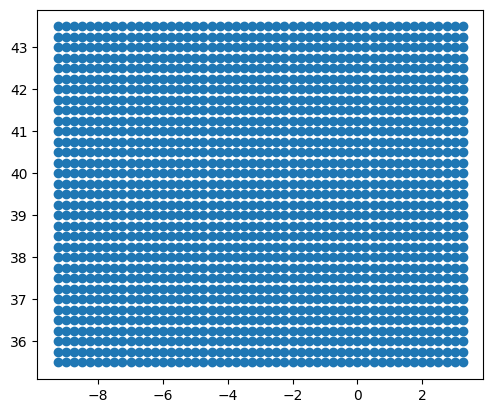

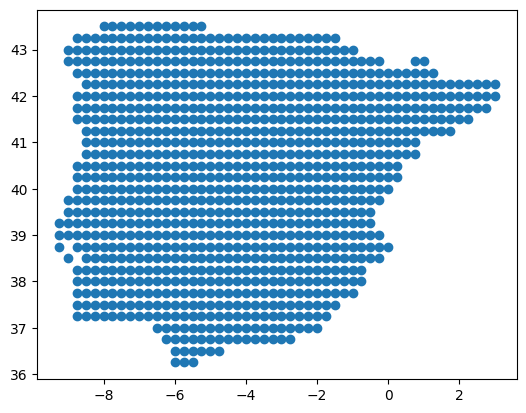

In [18]:
max5day_df = xr.open_dataset(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/ecde_proj_4_5_france/13_maximum_five_days_precipitation-projections-monthly-rcp_4_5-wrf381p-ipsl_cm5a_mr-r1i1p1-grid-v1.0.nc')
max5day_df = subset_iberia(max5day_df)
max5day_df = max5day_df.to_dataframe().reset_index()
max5day_df = filter_df_by_iberia(max5day_df, nuts_iberia, lat_col='lat', lon_col='lon')

In [24]:
max5day_df = max5day_df.rename(columns={'prAdjust': 'max_5_day'})

### SSP 585 and RCP 8.5

#### Clean

In [9]:
# ─── Inspect CMIP-6 grid against Iberia polygon (no data load) ──────────────
from pathlib import Path
import xarray as xr, geopandas as gpd, numpy as np
from shapely.vectorized import contains
CMIP6_FILE  = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/daily/pr_day_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_2021_v2.0.nc")
IBE_POLY    = nuts_iberia.copy().union_all().buffer(0.125)
# 1. open lazily, read only coordinate axes ----------------------------------
ds  = xr.open_dataset(CMIP6_FILE)
lat = ds["lat"].values                     # (580,)
lon0_360 = ds["lon"].values                # (1421,)  0…360°
lon = ((lon0_360 + 180) % 360) - 180       # convert to −180…180°

print(f"DS latitude range : {lat.min():.2f} → {lat.max():.2f}")
print(f"DS longitude range: {lon.min():.2f} → {lon.max():.2f}")

# 2. vectorised point-in-polygon --------------------------------------------
lon2d, lat2d = np.meshgrid(lon, lat, indexing="xy")
mask = contains(IBE_POLY, lon2d, lat2d)    # bool (lat, lon)

lat_valid = np.unique(lat2d[mask]).astype("float32")
lon_valid = np.unique(lon2d[mask]).astype("float32")
west, south, east, north = nuts_iberia.total_bounds
IBERIA_BBOX = {
    "min_lat": south,  # Minimum latitude
    "max_lat": north,  # Maximum latitude
    "min_lon": west,   # Minimum longitude
    "max_lon": east    # Maximum longitude
}
print("Iberia BBOX from IBE_POLY")
print(IBERIA_BBOX)
print(f"\nValid Iberia latitudes ({lat_valid.size}):",
      np.array2string(lat_valid[:10], precision=2, separator=', '), "…")
print(f"Valid Iberia longitudes ({lon_valid.size}):",
      np.array2string(lon_valid[:10], precision=2, separator=', '), "…")

# 3. bounding box of those valid cells
print("\nBounding box of Iberia cells in this file:")
print(f"  lat : {lat_valid.min():.2f} → {lat_valid.max():.2f}")
print(f"  lon : {lon_valid.min():.2f} → {lon_valid.max():.2f}")

ds.close()


DS latitude range : -59.88 → 89.88
DS longitude range: -179.88 → 179.88
Iberia BBOX from IBE_POLY
{'min_lat': 35.271704476000025, 'max_lat': 43.735114829000054, 'min_lon': -9.490672837999966, 'max_lon': 3.25861242000002}

Valid Iberia latitudes (33): [35.38, 35.88, 36.12, 36.38, 36.62, 36.88, 37.12, 37.38, 37.62, 37.88] …
Valid Iberia longitudes (51): [-9.38, -9.12, -8.88, -8.62, -8.38, -8.12, -7.88, -7.62, -7.38, -7.12] …

Bounding box of Iberia cells in this file:
  lat : 35.38 → 43.62
  lon : -9.38 → 3.12


In [10]:
import xarray as xr, numpy as np, tqdm
from shapely.vectorized import contains
from pathlib import Path
from dask import delayed

SRC_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/daily")
OUT_NC = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/cmip6_pr_iberia_ssp585.nc")
OUT_NC.unlink(missing_ok=True)

files = sorted(SRC_DIR.glob("pr_day_MPI-ESM1-2-LR_ssp585_*.nc"))

# mask (same code as above) ---------------------------------------------------
with xr.open_dataset(files[0]) as tmpl:
    lon = ((tmpl.lon.values + 180) % 360) - 180
    lat = tmpl.lat.values
lon2d, lat2d = np.meshgrid(lon, lat, indexing="xy")
mask = contains(nuts_iberia.union_all(), lon2d, lat2d)

# lazily build a list of masked datasets -------------------------------------
subsets = []
for f in tqdm.tqdm(files, desc="open+mask"):
    ds = xr.open_dataset(f, chunks={"time": 365})
    subsets.append(ds.where(mask))

# concat along time *without computing* ---------------------------------------
full = xr.concat(subsets, dim="time")

encoding = {"pr": {"dtype": "float32", "zlib": True, "complevel": 4}}
full.to_netcdf(OUT_NC, format="NETCDF4",
               unlimited_dims="time", encoding=encoding)

print("✔ Iberia subset written:", OUT_NC)


open+mask: 100%|██████████| 60/60 [00:02<00:00, 28.87it/s]


✔ Iberia subset written: /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/cmip6_pr_iberia_ssp585.nc


### Monthly Data

In [11]:


# Iberia bounding box ---------------------------------------------------------

def subset_iberia(ds: xr.Dataset | xr.DataArray,
                  lat_dim: str = "lat",
                  lon_dim: str = "lon") -> xr.Dataset | xr.DataArray:
    """
    Return the Iberia window of *ds* (lazy).  Handles a 0…360° longitude axis
    by wrapping it to –180…180° and sorting it once.

    Parameters
    ----------
    ds : Dataset | DataArray
    lat_dim, lon_dim : str   names of the spatial dimensions
    """
    # --- 1 · wrap longitudes if necessary -----------------------------------
    west, south, east, north = nuts_iberia.total_bounds      # lon/lat in °

    if float(ds[lon_dim].max()) > 180.0:
        print("greater")
        # (a) wrap
        lon_wrapped = (((ds[lon_dim] + 180.0) % 360.0) - 180.0)
        # (b) make a sorted copy of the *coordinate only* – cheap
        order = np.argsort(lon_wrapped.values)
        ds = ds.assign_coords({lon_dim: lon_wrapped}).isel({lon_dim: order})

    # 2. boolean masks for the 1-D coordinate axes
    lat_mask = (ds[lat_dim] >= south) & (ds[lat_dim] <= north)
    lon_mask = (ds[lon_dim] >= west)  & (ds[lon_dim] <= east)

    # 3. isel with index arrays (avoids broadcasting issues)
    ds = ds.isel(
        **{
            lat_dim: np.where(lat_mask)[0],
            lon_dim: np.where(lon_mask)[0],
        }
    )
    return ds
# example
#cmip6_df_iberia = subset_iberia(cmip6_df_iberia)


### $tp_{\mu}$

In [12]:


SRC_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/daily")
OUT_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_mu")
OUT_DIR.mkdir(parents=True, exist_ok=True)

files = sorted(SRC_DIR.glob("pr_day_MPI-ESM1-2-LR_ssp585_*.nc"))

# mask -----------------------------------------------------------------------
with xr.open_dataset(files[0]) as tmpl:
    lon = ((tmpl.lon.values + 180) % 360) - 180
    lat = tmpl.lat.values
lon2d, lat2d = np.meshgrid(lon, lat, indexing="xy")
mask_da = xr.DataArray(
    contains(nuts_iberia.union_all(), lon2d, lat2d),
    coords={"lat": lat, "lon": lon},
    dims=("lat", "lon"),
)

mu_enc = {"tp_mu": {"dtype": "float32", "zlib": True, "complevel": 4}}

for f in tqdm.tqdm(files, desc="process"):
    year = f.stem.split("_")[-2]          # → "2079"
    out_year = OUT_DIR / f"cmip6_pr_iberia_mu_{year}.nc"

    with xr.open_dataset(f, decode_times=True) as ds:
        ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
        ds = ds.transpose("time", "lat", "lon").where(mask_da).astype("float32")

        mu = ds["pr"].resample(time="MS").mean("time", skipna=False).rename("tp_mu")
        mu.to_netcdf(
            out_year,
            format="NETCDF4",
            encoding=mu_enc,
        )

print("✔ yearly monthly means written to →", OUT_DIR)


process: 100%|██████████| 60/60 [03:42<00:00,  3.70s/it]

✔ yearly monthly means written to → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_mu


In [14]:
 
MONTHLY_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_mu")
OUT_FILE    = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_mu.parquet")
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
if OUT_FILE.exists():
    OUT_FILE.unlink()                       # overwrite on rerun

schema = pa.schema([
    ("latitude",  pa.float32()),
    ("longitude", pa.float32()),
    ("month",     pa.timestamp("ms")),      # UTC month start
    ("tp_mu",     pa.float32()),
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")
for f in tqdm.tqdm(sorted(MONTHLY_DIR.glob("cmip6_pr_iberia_mu_*.nc")),
                   desc="Iberia monthly → parquet"):
    with xr.open_dataset(f) as ds:
        ds = subset_iberia(ds)                      # keep Dataset
        # wide→long: Dataset → DataFrame → reset_index (vectorised)
        df = (ds
              .to_dataframe()                       # cols: tp_mu ; idx: time, lat, lon
              .reset_index()                        # now explicit columns
              .rename(columns={"lat": "latitude",
                               "lon": "longitude",
                               "time": "month"})
              .astype({"latitude": "float32",
                       "longitude": "float32",
                       "tp_mu":   "float32"}))
        df["tp_mu"] = df["tp_mu"] * np.float32(86_400.0)
        df["month"] = pd.to_datetime(df["month"], utc=True)   # ms precision

        writer.write_table(pa.Table.from_pandas(df, schema=schema,
                                                preserve_index=False))
        del df
        gc.collect()
writer.close()
print("✔ tp_mu parquet written →", OUT_FILE)


Iberia monthly → parquet: 100%|██████████| 60/60 [00:08<00:00,  7.47it/s]

✔ tp_mu parquet written → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_mu.parquet


#### tp_hd

##### Historical Average Overall

In [15]:
# ---------------------------------------------------------------------------
# overall deviation: CMIP6 monthly mean minus nearest ERA5 climatology
# ---------------------------------------------------------------------------
from scipy.spatial import cKDTree

TP_MU_FILE = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_mu.parquet")
HIST_FILE  = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/"
                  "tp_historical_iberia_1950_1980.parquet")
OUT_HD     = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_hd_overall.parquet")
OUT_HD.unlink(missing_ok=True)

# ---- load ------------------------------------------------------------------
df   = pd.read_parquet(TP_MU_FILE)
clim = pd.read_parquet(HIST_FILE)

# unify longitude range to −180…180°
df["longitude"]   = (((df["longitude"]   + 180.0) % 360.0) - 180.0).astype("float32")
clim["longitude"] = (((clim["longitude"] + 180.0) % 360.0) - 180.0).astype("float32")

# ---- nearest-neighbour lookup ---------------------------------------------
tree = cKDTree(clim[["latitude","longitude"]].to_numpy(dtype="float32"))
_, idx = tree.query(df[["latitude","longitude"]].to_numpy(dtype="float32"), k=1)

df["hist_tp"] = clim["hist_tp"].to_numpy(dtype="float32")[idx]

# ---- deviation -------------------------------------------------------------
df["tp_hd"] = df["tp_mu"].astype("float32") - df["hist_tp"]

df[["month","latitude","longitude","tp_hd"]].to_parquet(OUT_HD, index=False)
print("✔ deviation from overall climatology →", OUT_HD)


✔ deviation from overall climatology → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_hd_overall.parquet


##### Non Seasonal Historical Average

In [16]:

# ── paths ─────────────────────────────────────────────────────────────────
TP_MU_FILE = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_mu.parquet")
HIST_M_FILE = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/historical/"
                   "tp_hist_monthly_iberia_1950_1980.parquet")
OUT_HD_M    = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_hd_monthly.parquet")
OUT_HD_M.unlink(missing_ok=True)

# ── load CMIP6 monthly means ──────────────────────────────────────────────
df = pd.read_parquet(TP_MU_FILE)


# numeric calendar month (1–12) for climatology match
df["MO"] = pd.to_datetime(df["month"]).dt.month.astype("int8")

# ensure longitude range −180…180°
df["longitude"] = (((df["longitude"] + 180.0) % 360.0) - 180.0).astype("float32")

# ── load historical month-specific means ──────────────────────────────────
clim = pd.read_parquet(HIST_M_FILE)


# ── build cKDTree on unique ERA5 gridpoints ───────────────────────────────
pivot = clim.pivot_table(index=["latitude", "longitude"], columns="MO", values="hist_tp")
coords = np.array(pivot.index.to_list(), dtype="float32")      # N × 2 (lat, lon)
hist_mat = pivot.to_numpy(dtype="float32")                     # N × 12

tree = cKDTree(coords)

# ── nearest neighbour lookup for each CMIP6 row ───────────────────────────
_, idx = tree.query(df[["latitude", "longitude"]].to_numpy(dtype="float32"), k=1)
df["hist_tp"] = hist_mat[idx, df["MO"] - 1]                    # 0-based month

# ── deviation ─────────────────────────────────────────────────────────────
df["tp_hd"] = df["tp_mu"] - df["hist_tp"]

# ── tidy & save ───────────────────────────────────────────────────────────
df[["month", "latitude", "longitude", "tp_hd"]].to_parquet(OUT_HD_M, index=False)

print("✔ deviation from month-specific climatology →", OUT_HD_M)


✔ deviation from month-specific climatology → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_hd_monthly.parquet


### $tp_{\sigma}$

In [18]:


SRC_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/daily")
OUT_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_sigma")
OUT_DIR.mkdir(parents=True, exist_ok=True)

files = sorted(SRC_DIR.glob("pr_day_MPI-ESM1-2-LR_ssp585_*.nc"))

# mask -----------------------------------------------------------------------
with xr.open_dataset(files[0]) as tmpl:
    lon = ((tmpl.lon.values + 180) % 360) - 180
    lat = tmpl.lat.values
lon2d, lat2d = np.meshgrid(lon, lat, indexing="xy")
mask_da = xr.DataArray(
    contains(nuts_iberia.union_all(), lon2d, lat2d),
    coords={"lat": lat, "lon": lon},
    dims=("lat", "lon"),
)

std_enc = {"tp_std": {"dtype": "float32", "zlib": True, "complevel": 4}}
for f in tqdm.tqdm(files, desc="process"):
    year = f.stem.split("_")[-2]          # → "2079"
    out_year = OUT_DIR / f"cmip6_pr_iberia_std_{year}.nc"

    with xr.open_dataset(f, decode_times=True) as ds:
        ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
        ds = ds.transpose("time", "lat", "lon").where(mask_da).astype("float32")
        # 86 400 s per day; 1 kg m⁻² = 1 mm
        sigma = (
            ds["pr"] * np.float32(86_400.0)                      # kg m⁻² s⁻¹ → mm day⁻¹
        ).resample(time="MS").std("time", skipna=False).rename("tp_std")

        sigma.to_netcdf(
            out_year,
            format="NETCDF4",
            encoding=std_enc,
        )

print("✔ yearly monthly means written to →", OUT_DIR)


process: 100%|██████████| 60/60 [12:44<00:00, 12.73s/it] 

✔ yearly monthly means written to → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_sigma


In [20]:
 
MONTHLY_DIR = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_sigma")
OUT_FILE    = Path("/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_stdmmday.parquet")
OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
if OUT_FILE.exists():
    OUT_FILE.unlink()                       # overwrite on rerun

schema = pa.schema([
    ("latitude",  pa.float32()),
    ("longitude", pa.float32()),
    ("month",     pa.timestamp("ms")),      # UTC month start
    ("tp_std",     pa.float32()),
])
writer = pq.ParquetWriter(OUT_FILE, schema, compression="snappy")
for f in tqdm.tqdm(sorted(MONTHLY_DIR.glob("cmip6_pr_iberia_std_*.nc")),
                   desc="Iberia monthly → parquet"):
    with xr.open_dataset(f) as ds:
        ds = subset_iberia(ds)                      # keep Dataset
        # wide→long: Dataset → DataFrame → reset_index (vectorised)
        df = (ds
              .to_dataframe()                       # cols: tp_std ; idx: time, lat, lon
              .reset_index()                        # now explicit columns
              .rename(columns={"lat": "latitude",
                               "lon": "longitude",
                               "time": "month"})
              .astype({"latitude": "float32",
                       "longitude": "float32",
                       "tp_std":   "float32"}))
        df["month"] = pd.to_datetime(df["month"], utc=True)   # ms precision

        writer.write_table(pa.Table.from_pandas(df, schema=schema,
                                                preserve_index=False))
        del df
        gc.collect()
writer.close()
print("✔ tp_std parquet written →", OUT_FILE)


Iberia monthly → parquet: 100%|██████████| 60/60 [00:04<00:00, 14.94it/s]

✔ tp_std parquet written → /Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/cmip6/MPI-ESM1-2LR/ssp585/monthly/tp_stdmmday.parquet


### ECDE

#### *cdd*

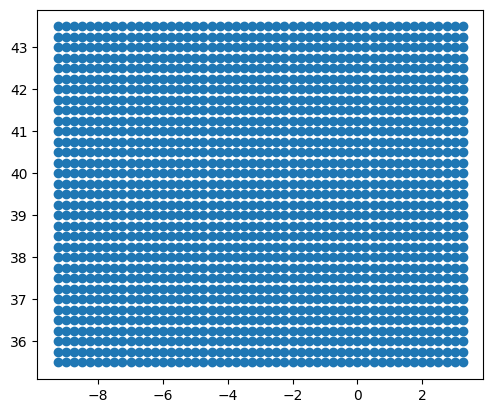

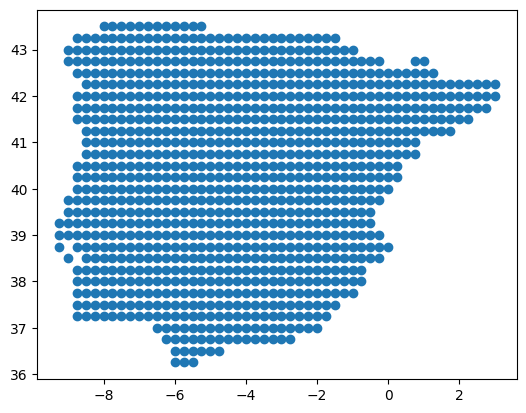

In [23]:
cdd_df = xr.open_dataset(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/ecde_IPSL-CM5A-MR_WRF381P/rcp8_5/18_consecutive_dry_days-projections-monthly-rcp_8_5-wrf381p-ipsl_cm5a_mr-r1i1p1-grid-v1.0.nc')
cdd_df = subset_iberia(cdd_df)
cdd_df = cdd_df.to_dataframe().reset_index()
cdd_df = filter_df_by_iberia(cdd_df, nuts_iberia, lat_col='lat', lon_col='lon')

In [24]:
cdd_df.to_parquet('/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/ecde_IPSL-CM5A-MR_WRF381P/rcp8_5/monthly/cdd_iberia_1951_2100.parquet')


#### $tp_{5d}$

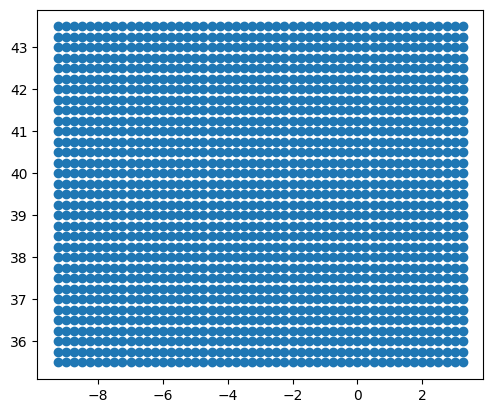

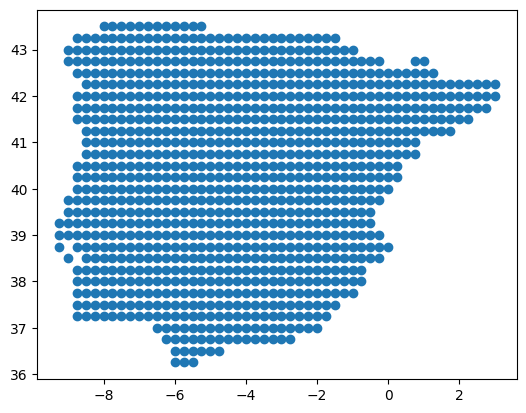

In [26]:
max5day_df = xr.open_dataset(r'/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/ecde_IPSL-CM5A-MR_WRF381P/rcp8_5/13_maximum_five_days_precipitation-projections-monthly-rcp_8_5-wrf381p-ipsl_cm5a_mr-r1i1p1-grid-v1.0.nc')
max5day_df = subset_iberia(max5day_df)
max5day_df = max5day_df.to_dataframe().reset_index()
max5day_df = filter_df_by_iberia(max5day_df, nuts_iberia, lat_col='lat', lon_col='lon')

In [27]:
max5day_df = max5day_df.rename(columns={'prAdjust': 'max_5_day'})

In [28]:
max5day_df.to_parquet('/Volumes/Dhruv_External_Disk/climate_data/precipitation/projections/ecde_IPSL-CM5A-MR_WRF381P/rcp8_5/monthly/max5day_iberia_1951_2100.parquet')
